In [2]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os

In [36]:
datagen = N2V_DataGenerator()
img = datagen.load_imgs_from_directory(directory="./../domes/", filter='*processed.tif', dims='ZYX')
# imgs[0] = imgs[0][...,:3]
imgs = []
print('shape without alpha:    ',img[0].shape)
for i in img[0][0]:
    col_sum = np.sum(i, axis=0)
    zero, _ = np.where(col_sum==0)
    i = np.delete(i, zero, axis = 1) # Remove the columns that do not have light.
    # plt.plot(col_sum)
    # plt.figure(figsize=(16,8))
    # plt.imshow(i)
    # plt.show()
    imgs.append(np.array(i))
    # break

shape without alpha:     (1, 320, 796, 796, 1)


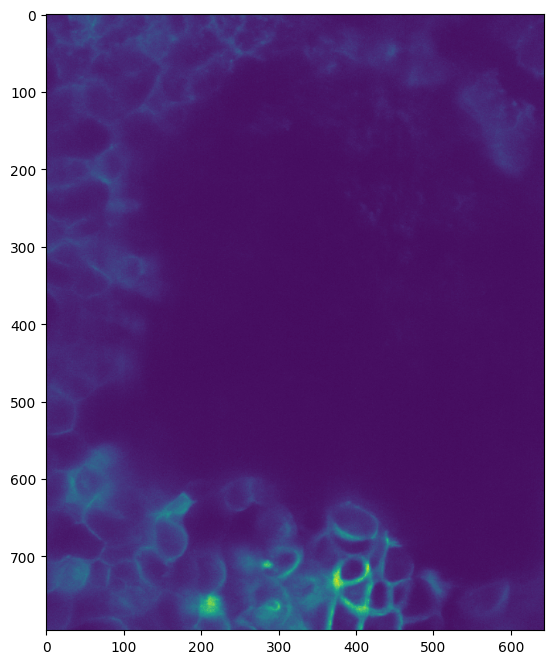

In [37]:
plt.figure(figsize=(16,8))
plt.imshow(imgs[300])
plt.show()

38076
(10000, 64, 64, 1) (8076, 64, 64, 1)


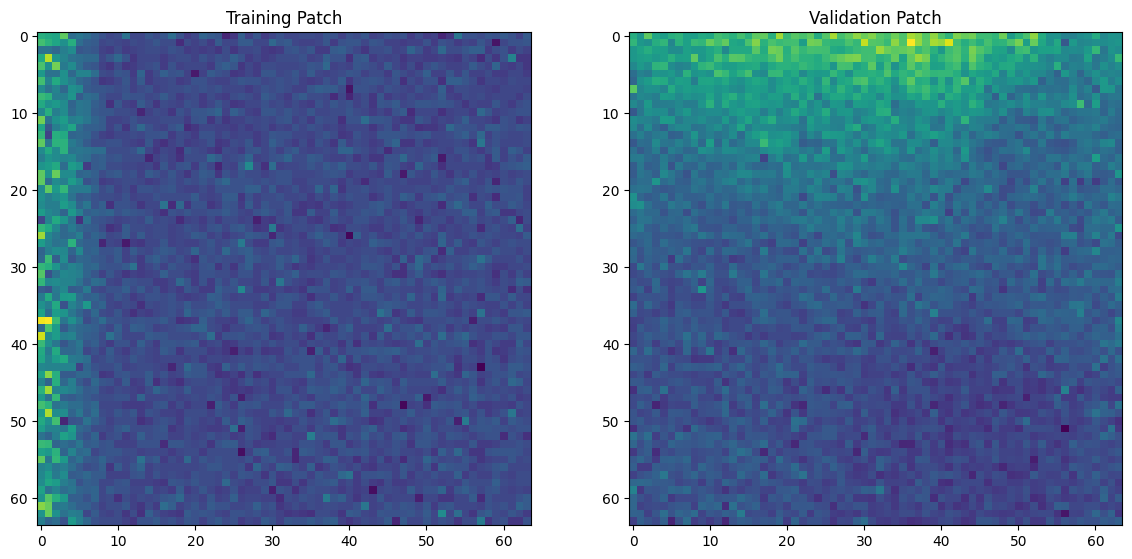

In [59]:
patch_shape=(64,64)
patches = []
for im in imgs:
    # plt.figure(figsize=(16,8))
    # plt.imshow(im)
    # plt.show()
    # patches = datagen.generate_patches_from_list(im, shape=patch_shape)
    for i in range(0, im.shape[0]-patch_shape[0], patch_shape[0]):
        for j in range(0, im.shape[1]-patch_shape[1], patch_shape[1]):
            patch = im[i:i+patch_shape[0], j:j+patch_shape[1]]
            # print(np.array(patch).shape)
            patches.append(patch)

print(len(patches))
patches = np.array(patches)
X = patches[:10000]
X_val = patches[30000:]
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...])
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...])
plt.title('Validation Patch');
print(X.shape, X_val.shape)

In [60]:
config = N2VConfig(X, unet_kern_size=3, 
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/128), train_epochs=25, train_loss='mse', 
                   batch_norm=True, train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['26.803812'],
 'stds': ['5.840313'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 25,
 'train_steps_per_epoch': 78,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [61]:
# a name used to identify the model --> change this to something sensible!
model_name = '2d_images_from_stack'
# the base directory in which our model will live
basedir = 'models_test'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

In [62]:
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 8076/8076 [00:03<00:00, 2637.93it/s]


Epoch 1/25
 6/78 [=>............................] - ETA: 11:49 - loss: 0.5455 - n2v_mse: 0.5455 - n2v_abs: 0.5144

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


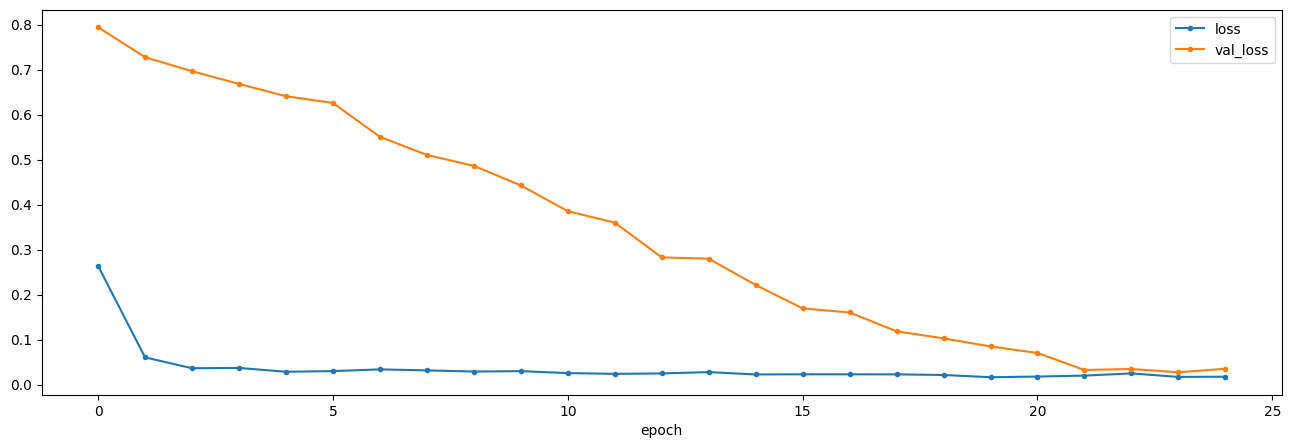

In [20]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

In [21]:
model.export_TF(name='blacklineusedfortrainingtest', 
                description='2D image trained using black line.', 
                authors=["domedeum"],
                test_img=X_val[0], axes='YXC',
                patch_shape=patch_shape)

1/1 [==============================] - 1s 798ms/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.


d:\Python_vscode\venv_tf\Lib\site-packages\csbdeep\utils\tf.py:177: UserWarning: 
***IMPORTANT NOTE***

You are using 'tensorflow' 2.x, hence it is likely that the exported model *will not work*
in associated ImageJ/Fiji plugins (e.g. CSBDeep and StarDist).

If you indeed have problems loading the exported model in Fiji, the current workaround is
to load the trained model in a Python environment with installed 'tensorflow' 1.x and then
export it again. If you need help with this, please read:

https://gist.github.com/uschmidt83/4b747862fe307044c722d6d1009f6183

  warnings.warn(\


INFO:tensorflow:SavedModel written to: C:\Users\SPIM\AppData\Local\Temp\tmpjbpy8g3v\model\saved_model.pb

Model exported in BioImage ModelZoo format:
D:\Python_vscode\n2v_2d_black_line\models_test\n2v_trained_with_black_line_2d\export.bioimage.io.zip
